# Modelo Propuesto

## Librerías utilizadas

In [18]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
import pandas as pd
import warnings
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
warnings.filterwarnings("ignore")

Iniciamos cargando el dataset

In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/shadiajaafar1/ParcialML2/main/dataset_final%20(1).csv')
df

,isFraud,TransactionDT,TransactionAmt,card2,card3,C3,C5,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_credit,D3
0,0,86400,68.50,361.0,150.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,13.0
1,0,86401,29.00,404.0,150.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,8.0
2,0,86469,59.00,490.0,150.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0
3,0,86499,50.00,567.0,150.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,86506,50.00,514.0,150.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,15811047,49.00,361.0,150.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,30.0
590536,0,15811049,39.50,225.0,150.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0
590537,0,15811079,30.95,595.0,150.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,8.0
590538,0,15811088,117.00,481.0,150.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Imputación y Balanceo de Datos
Para esto utilizaremos la imputación KNN y ADASYN para crear muestras sintéticas.

In [37]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

imputer = KNNImputer(n_neighbors=5)
X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

## Entrenamiento del Modelo Stacking
- **Modelos Base:** Random Forest, XGBoost, Random Forest Balanceado
- **Modelo Meta:** Regresión Logística

In [29]:
estimators = [
    ('rf', RandomForestClassifier(max_depth=20, random_state=42)),
    ('xgb', XGBClassifier(max_depth=7, n_estimators=200, random_state=42)),
    ('brf', BalancedRandomForestClassifier(max_depth=30, n_estimators=200, random_state=42))
]

# Definición del Meta-Modelo (Regresión Logística)
meta_model = LogisticRegression(max_iter=1000, random_state=42)

# Creación del StackingClassifier
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=meta_model, cv=StratifiedKFold(n_splits=5))

# Medir el tiempo de entrenamiento y predicción
start_time = time.time()

# Agregar barra de progreso
with tqdm(total=len(estimators), desc="Entrenamiento de modelos base") as pbar:
    for name, estimator in estimators:
        estimator.fit(X_train_resampled, y_train_resampled)
        pbar.update(1)

stacking_clf.fit(X_train_resampled, y_train_resampled)
elapsed_time = time.time() - start_time

# Predicciones en el conjunto de prueba
y_pred = stacking_clf.predict(X_test)
y_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]

# Evaluación del modelo
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Elapsed Time: {elapsed_time:.4f} seconds")

# Crear un DataFrame con las métricas
metrics_df = pd.DataFrame({
    'Metric': ['ROC AUC', 'Precision', 'Recall', 'F1 Score', 'Elapsed Time'],
    'Score': [roc_auc, precision, recall, f1, elapsed_time]
})


Entrenamiento de modelos base: 100%|██████████| 3/3 [02:09<00:00, 43.30s/it]


ROC AUC: 0.8896
Precision: 0.7838
Recall: 0.2581
F1 Score: 0.3884
Elapsed Time: 791.3027 seconds
         Metric       Score
0       ROC AUC    0.889560
1     Precision    0.783822
2        Recall    0.258133
3      F1 Score    0.388367
4  Elapsed Time  791.302695


- ROC AUC (0.8896):

Este es un buen valor, indicando que el modelo tiene una alta capacidad para distinguir entre clases positivas y negativas. Un valor cercano a 1 es ideal.

- Precision (0.7838):

Este valor muestra que el 78.38% de las predicciones positivas del modelo son correctas. Es un buen indicador, especialmente en casos donde los falsos positivos deben ser minimizados.

- Recall (0.2581):

Este valor es bastante bajo, indicando que el modelo solo está identificando correctamente el 25.81% de los casos positivos reales. Esto sugiere que el modelo está fallando en detectar muchos casos de fraude (falsos negativos).

- F1 Score (0.3884):

La puntuación F1 es la media armónica de la precisión y el recuerdo. Un valor de 0.3884 es relativamente bajo, reflejando el balance deficiente entre precisión y recuerdo. Indica que aunque el modelo es preciso cuando predice fraudes, no detecta suficientes casos de fraude.

## Evaluación del Modelo
Matriz de Confusión y Curva Roc

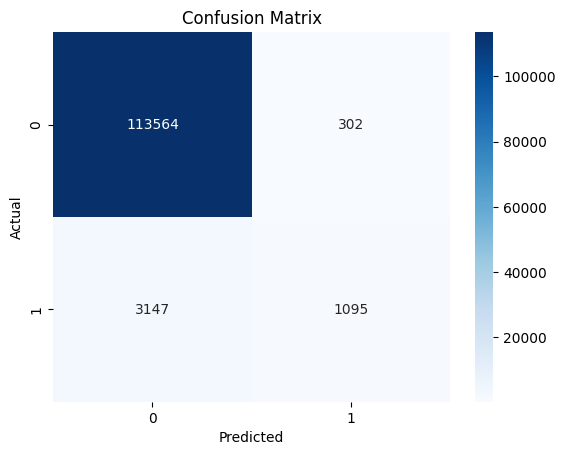

In [33]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

- **Verdaderos Negativos (TN): 113564**

El modelo ha predicho correctamente 113564 transacciones como no fraudulentas. Esto muestra que el modelo es bastante bueno en identificar transacciones legítimas.

- **Falsos Positivos (FP): 302**

El modelo ha identificado incorrectamente 302 transacciones como fraudulentas cuando no lo son. Este número es bajo, lo que indica que el modelo tiene una alta precisión y no genera muchas alarmas falsas.

- **Falsos Negativos (FN): 3147**

El modelo ha fallado en identificar 3147 transacciones fraudulentas, clasificándolas incorrectamente como no fraudulentas.

- **Verdaderos Positivos (TP): 1095**

El modelo ha identificado correctamente 1095 transacciones como fraudulentas.

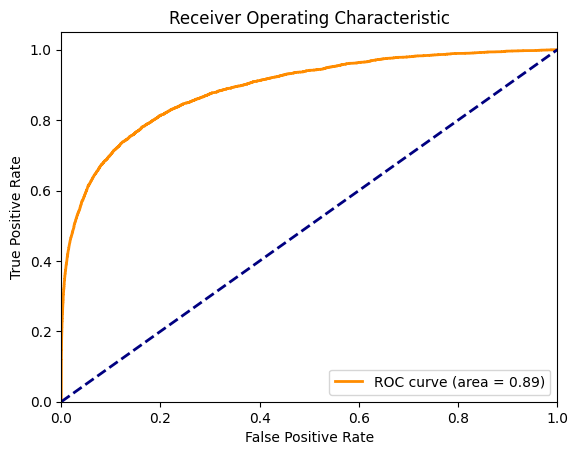

In [34]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

La curva ROC se encuentra significativamente por encima de la diagonal (línea punteada), lo cual muestra que el modelo tiene un buen poder discriminativo. Una curva ROC que sigue de cerca la esquina superior izquierda indica un modelo con alta sensibilidad y especificidad.

Un AUC de 0.89 es indicativo de un buen equilibrio entre sensibilidad y especificidad. Esto implica que el modelo de stacking tiene un excelente desempeño en términos de su capacidad para distinguir entre clases.

## Análisis Importancia de las Variables

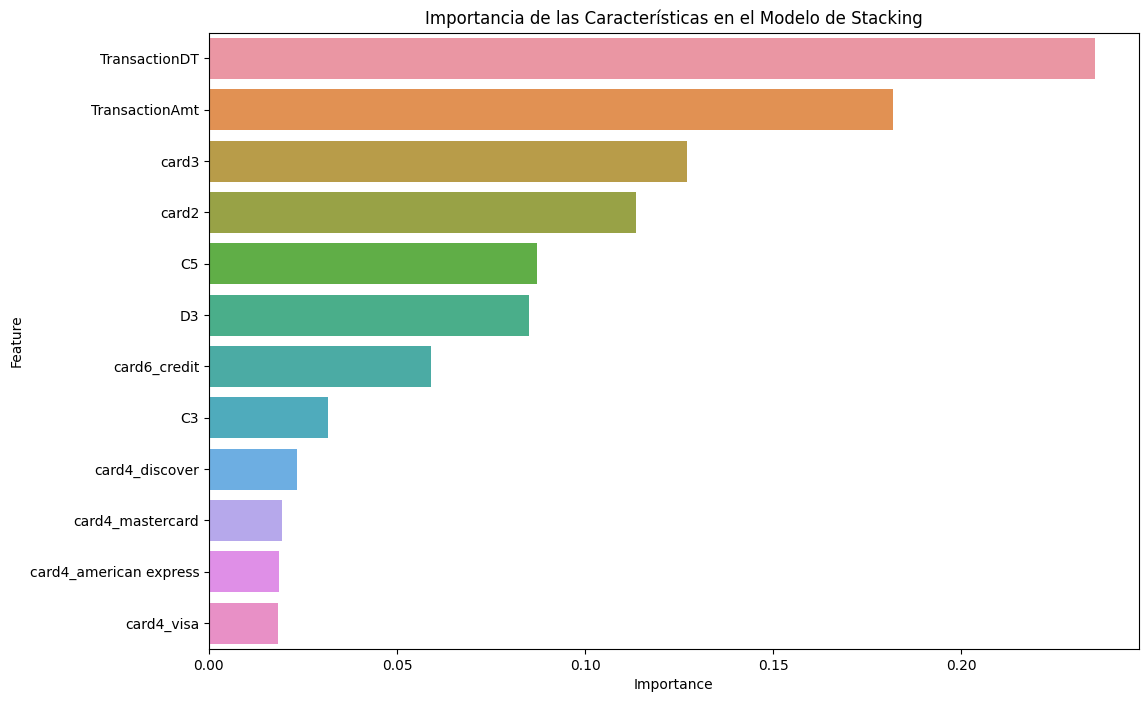

In [49]:
feature_importances = np.zeros(X.shape[1])
for name, estimator in estimators:
    if hasattr(estimator, 'feature_importances_'):
        feature_importances += estimator.feature_importances_

# Normalizar las importancias
feature_importances /= len(estimators)

# Crear un DataFrame para las importancias
feature_importances_df = pd.DataFrame({
    'Feature': df.drop('isFraud', axis=1).columns,
    'Importance': feature_importances
})

# Ordenar por importancia
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Graficar las importancias de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Importancia de las Características en el Modelo de Stacking')
plt.show()

- **TransactionDT y TransactionAmt**
Estas dos características son las más influyentes, lo que sugiere que la temporalidad y la cantidad de la transacción son los factores más críticos en la detección de fraude.

- **Variables de Tarjeta (card2, card3, card4)**
La información específica de la tarjeta (como los códigos y el tipo de tarjeta) también juega un papel importante en la identificación de fraudes.

- **Otras variables (C5, D3, C3)**
Aunque no está claro a partir de los nombres qué representan exactamente estas características, su alta importancia sugiere que contienen información relevante y distintiva que ayuda a identificar transacciones fraudulentas.